# Gradient recovery and inversion under Secure Aggregation via gradient supression attack.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

from federated_learning import FL_server, FL_SGD_client_classification, setup_users_classification
from utility import check_gradient
from gradient_inversion import gradient_inversion, plot

# Evading Secure Aggregation via gradient supression

## Setup

In [2]:
num_users = 10
batch_size = 16
local_training_set_size = 32

dataset, _ = tf.keras.datasets.mnist.load_data()
input_shape = (28, 28, 1)
num_classes = 10
# Pick target user for gradient-suppression-based SA evasion
target_user = 0

# Model
def make_model(input_shape, num_classes):
    xin = tf.keras.layers.Input(input_shape)
    
    x = tf.keras.layers.Conv2D(32, 3, 1, activation='relu')(xin)
    x = tf.keras.layers.AvgPool2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, 1, activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(num_classes)(x)
    y = tf.keras.layers.Softmax()(x)
    
    model = tf.keras.Model(inputs=xin, outputs=y)
    return model

## Setup users FL

In [3]:
def parse_mnist(x):
    x = (x / (255/2) - 1)
    x = x[:,:,:,np.newaxis]
    return x

model = make_model(input_shape, num_classes)
users = setup_users_classification(
    FL_SGD_client_classification,
    num_users,
    model,
    dataset,
    batch_size,
    local_training_set_size,
    parse_mnist
)

## Setup Gradient suppression

In [4]:
from utility import init_list_variables

def zero_all_network(var):
    var = init_list_variables(model.trainable_variables)
    return var

suppressing_technique = zero_all_network

## Run FL for one round

In [5]:
FL = FL_server(users, model, suppressing_technique, target=target_user)
# Run FL
FL.models_distribution()
# Get secure aggregation output
agg = FL.SA()

# check if gradient has been recovered
recovered_gradient = check_gradient(agg, users[target_user].gradient)
print(f'\tRecovered_gradient: {recovered_gradient}')

layer: 0 with shape (288,) recovered?: True
layer: 1 with shape (32,) recovered?: True
layer: 2 with shape (18432,) recovered?: True
layer: 3 with shape (64,) recovered?: True
layer: 4 with shape (77440,) recovered?: True
layer: 5 with shape (10,) recovered?: False
	Recovered_gradient: 0.999896121164274


# Invert recovered gradient

In [6]:
num_iter = 1500
without_last_bias = True
rng_seed = None
w_reg = 1 / 25000
setps_lrs = [1000, 1250]

class lr_schlr(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, steps):
        self.learning_rate = initial_learning_rate
        self.steps = steps 

    def __call__(self, step):
        if step in self.steps:
            self.learning_rate = self.learning_rate *.1
            print(f"\t[Scaling learning rate: {self.learning_rate}]")
        return self.learning_rate
    
opt = tf.keras.optimizers.Adam(lr_schlr(.1, setps_lrs))

## Setup gradient inversion

In [7]:
inv_g, _, logs = gradient_inversion(
    model,
    agg,
    opt,
    num_iter,
    batch_size,
    input_shape,
    num_classes, 
    without_last_bias,
    w_reg,
    rng_seed
)

Running inversion...
	[0%] loss: 1.2719085216522217
	[10%] loss: 0.027946019545197487
	[20%] loss: 0.016531391069293022
	[30%] loss: 0.015095585957169533
	[40%] loss: 0.01325434073805809
	[50%] loss: 0.012362491339445114
	[60%] loss: 0.011116664856672287
	[Scale Learning rate: 0.010000000000000002]
	[70%] loss: 0.009228207170963287
	[80%] loss: 0.009126379154622555
	[Scale Learning rate: 0.0010000000000000002]
	[90%] loss: 0.008921388536691666


## Plot inverted gradient (unsorted)

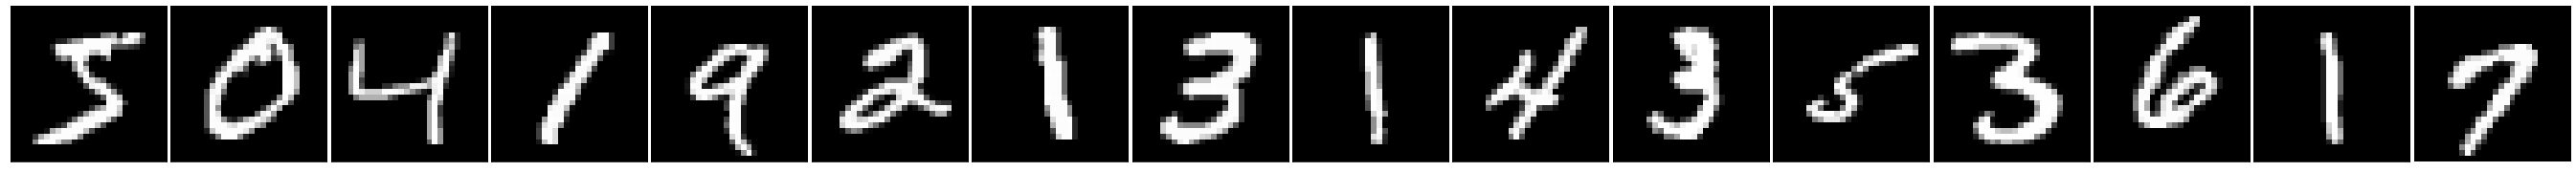

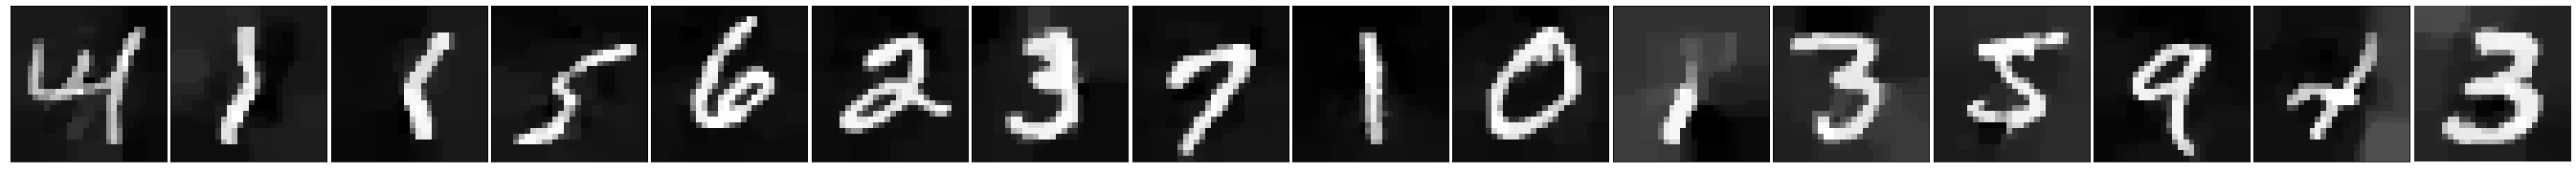

In [8]:
gt = users[target_user].data[0][:,:,:,0]
recovered = inv_g[:,:,:,0]

cmap = "gray"
# Ground truth 
fig, ax = plot(gt, cmap=cmap);
# Recovered
fig, ax = plot(recovered, cmap=cmap);